# Creation of a subsample from the MovieLens 25M dataset

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch_geometric.data import download_url, extract_zip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# download the 25M dataset if needed
#ml_25m_url = 'https://files.grouplens.org/datasets/movielens/ml-25m.zip'
#extract_zip(download_url(ml_25m_url, '.'), '.')

In [4]:
rating_path = './ml-25m/ratings.csv'
ratings = pd.read_csv(rating_path)

In [ ]:
len(ratings)

25000095

In [5]:
# Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.
# We convert to a readable timestamp
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [6]:
ratings['year'] = ratings['timestamp'].dt.year
#ratings['month'] = ratings['timestamp'].dt.month
ratings.head()

,userId,movieId,rating,timestamp,year
0,1,296,5.0,2006-05-17 15:34:04,2006
1,1,306,3.5,2006-05-17 12:26:57,2006
2,1,307,5.0,2006-05-17 12:27:08,2006
3,1,665,5.0,2006-05-17 15:13:40,2006
4,1,899,3.5,2006-05-17 12:21:50,2006


[Text(0.5, 1.0, 'Number of ratings by year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Num ratings')]

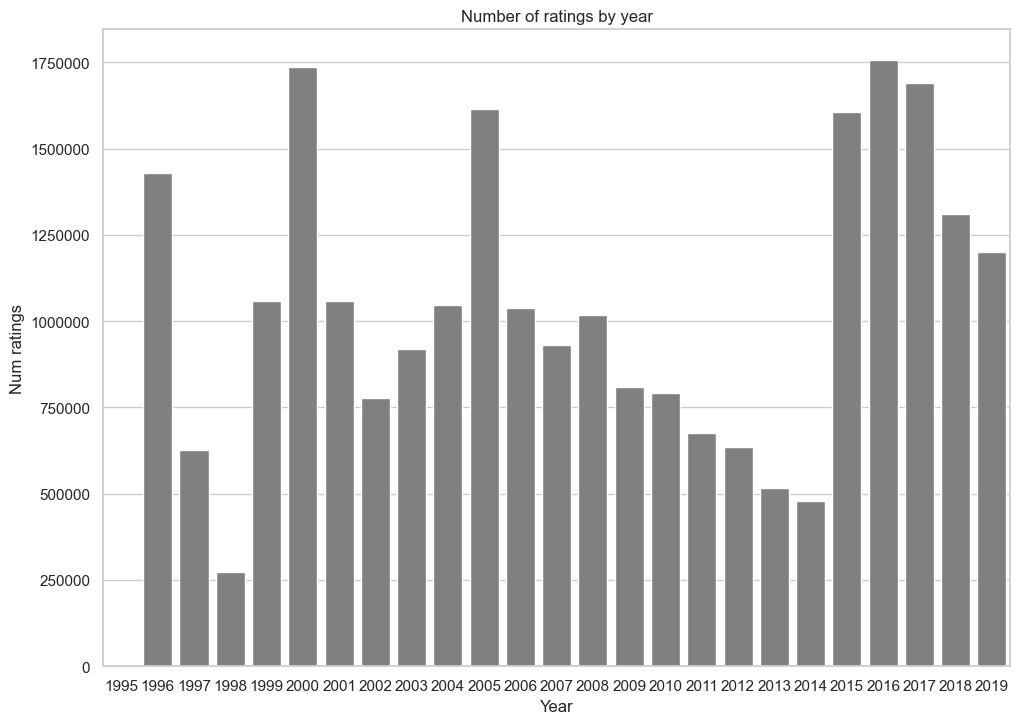

In [ ]:
# Plot number of ratings per year
sns.set_theme(style='whitegrid',rc={'axes.formatter.limits': (-8, 9), 'figure.figsize':(11.7,8.27)})
sns.barplot(x=ratings.year.value_counts().index, y=ratings.year.value_counts(), color='gray').set(title='Number of ratings by year', xlabel='Year', ylabel='Num ratings')

In [9]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
year         0
dtype: int64

In [10]:
ratings.duplicated().sum()

0

In [7]:
threshold = 3
print('The positivity threshold is ', threshold)
print(f'The percentage of reviews with a rating at least {threshold}: {round(len(ratings[ratings.rating>=3])/len(ratings)*100,2)}%')
print('These are the ones we keep.')

ratings = ratings[ratings.rating>=3]

The positivity threshold is  3
The percentage of reviews with a rating at least 3: 82.11%
These are the ones we keep.


[Text(0.5, 1.0, 'Number of ratings by year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Num ratings')]

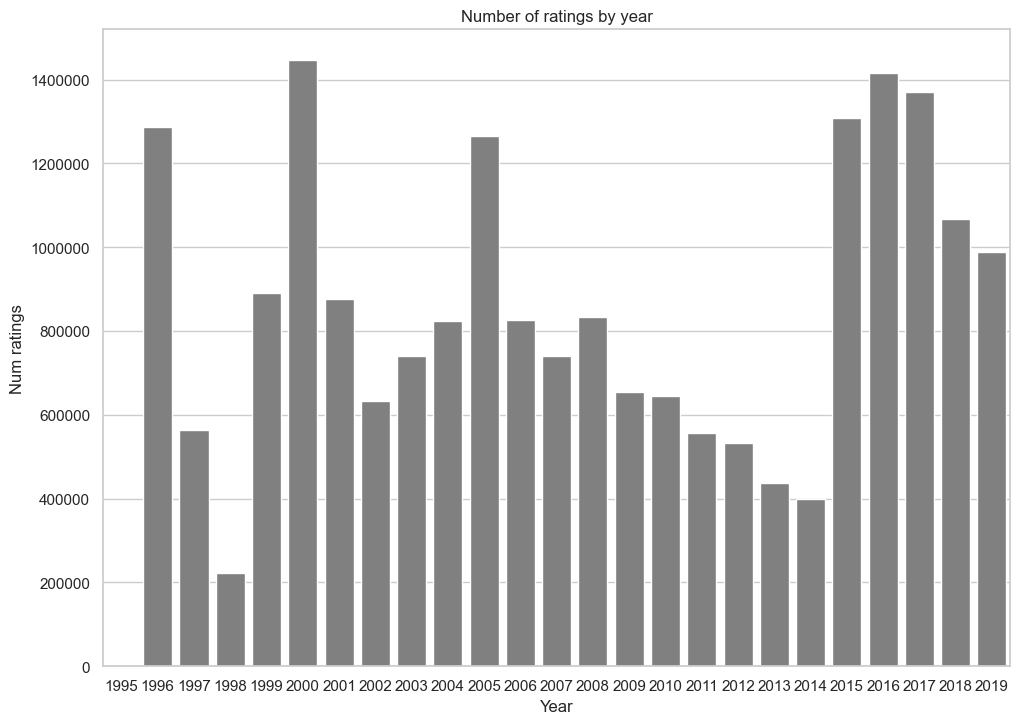

In [8]:
# Plot number of ratings per year after removing reviews under the threshold
sns.set_theme(style='whitegrid',rc={'axes.formatter.limits': (-8, 9), 'figure.figsize':(11.7,8.27)})
sns.barplot(x=ratings.year.value_counts().index, y=ratings.year.value_counts(), color='gray').set(title='Number of ratings by year', xlabel='Year', ylabel='Num ratings')

In [10]:
ratings_2018_2019 = ratings[ratings['year'] >= 2018].copy() # We take a sample of ratings from years 2018-2019
len(ratings_2018_2019), len(ratings)

(2054576, 20527057)

In [12]:
def print_stats(sample):
    user_counts = sample.userId.value_counts()
    print('Number of ratings in sample: ', len(sample))
    print('Total users in sample: ', len(user_counts))
    print('Users with less than 3 ratings: ', len(user_counts[user_counts < 3]))
    print('Users with less than 5 ratings: ', len(user_counts[user_counts < 5]))
    print('Users with less than 10 ratings: ', len(user_counts[user_counts < 10]))
    print('Users with less than 20 ratings: ', len(user_counts[user_counts < 20]))
    print()
    movie_counts = sample.movieId.value_counts()
    print('Total movies: ', len(movie_counts))
    print('Movies with less than 3 ratings: ', len(movie_counts[movie_counts < 3]))
    print('Movies with less than 5 ratings: ', len(movie_counts[movie_counts < 5]))
    print('Movies with less than 10 ratings: ', len(movie_counts[movie_counts < 10]))
    print('Movies with more than 50 ratings: ', len(movie_counts[movie_counts > 50]))
    
    print()
    print('Minimum number of ratings a user has in this subsample: ', user_counts.min())
    print('Maximum number of ratings a user has in this subsample: ', user_counts.max())
    print('Minimum number of ratings a movie has in this subsample: ', movie_counts.min())
    print('Maximum number of ratings a movie has in this subsample: ', movie_counts.max())


## Subset 1

We take a random subsample of 2000 users from the first subset (all ratings 2018-2019).

In [14]:
userids = ratings_2018_2019.userId.unique()
np.random.seed(0)
sample_2000 = np.random.choice(userids, size=2000, replace=False) # Let's keep random 1000 users
print(f'There are {len(userids)} users active in 2018-2019. We randomly sample {len(sample_2000)} of them.')

subsample_2000 = ratings_2018_2019[ratings_2018_2019.userId.isin(sample_2000)]
print(f'After sampling 5000 random users. We have {len(subsample_2000)} ratings and {len(subsample_2000.movieId.unique())} unique movies.')


There are 18469 users active in 2018-2019. We randomly sample 2000 of them.
After sampling 5000 random users. We have 222962 ratings and 15225 unique movies.


In [15]:
print_stats(subsample_2000)

Number of ratings in sample:  222962
Total users in sample:  2000
Users with less than 3 ratings:  59
Users with less than 5 ratings:  100
Users with less than 10 ratings:  185
Users with less than 20 ratings:  342

Total movies:  15225
Movies with less than 3 ratings:  8780
Movies with less than 5 ratings:  10531
Movies with less than 10 ratings:  12153
Movies with more than 50 ratings:  949

Minimum number of ratings a user has in this subsample:  1
Maximum number of ratings a user has in this subsample:  2122
Minimum number of ratings a movie has in this subsample:  1
Maximum number of ratings a movie has in this subsample:  854


In [16]:
subsample_2000.to_csv('./data/1_subsample_2018_2019_2000_users.csv', index=False)

## Subset 2

From the subsample of 2000 users we now remove users with less than 10 ratings and all movies with less than 10 ratings.

In [17]:
# Remove users below 10 ratings
user_counts_ratings_2018_2019_5k = subsample_2000.userId.value_counts()
users_more_than_10_ratings_5k = user_counts_ratings_2018_2019_5k[user_counts_ratings_2018_2019_5k > 10].index
subsample_2000_pruned = subsample_2000[subsample_2000.userId.isin(users_more_than_10_ratings_5k)]

# Remove movies below 10 ratings
pruned_movie_counts = subsample_2000_pruned.movieId.value_counts()
movies_more_than_10_ratings = pruned_movie_counts[pruned_movie_counts > 10].index
subsample_2000_pruned = subsample_2000_pruned[subsample_2000_pruned.movieId.isin(movies_more_than_10_ratings)]

# Remove users below 10 ratings if there are any because of movie removal
pruned_user_counts = subsample_2000_pruned.userId.value_counts()
users_more_than_10_ratings = pruned_user_counts[pruned_user_counts > 10].index
subsample_2000_pruned = subsample_2000_pruned[subsample_2000_pruned.userId.isin(users_more_than_10_ratings)]

In [18]:
print_stats(subsample_2000_pruned)

Number of ratings in sample:  192680
Total users in sample:  1782
Users with less than 3 ratings:  0
Users with less than 5 ratings:  0
Users with less than 10 ratings:  0
Users with less than 20 ratings:  179

Total movies:  2891
Movies with less than 3 ratings:  0
Movies with less than 5 ratings:  0
Movies with less than 10 ratings:  0
Movies with more than 50 ratings:  946

Minimum number of ratings a user has in this subsample:  11
Maximum number of ratings a user has in this subsample:  1150
Minimum number of ratings a movie has in this subsample:  11
Maximum number of ratings a movie has in this subsample:  851


In [19]:
subsample_2000_pruned.to_csv('./data/2_subsample_2018_2019_2000_users_pruned.csv', index=False)

## Subset 3

We take a random subsample of 1000 users from the first subset (all ratings 2018-2019).

In [20]:
userids = ratings_2018_2019.userId.unique()
np.random.seed(0)
sample_1000 = np.random.choice(userids, size=1000, replace=False) # Let's keep random 1000 users
print(f'There are {len(userids)} users active in 2018-2019. We randomly sample {len(sample_1000)} of them.')

There are 18469 users active in 2018-2019. We randomly sample 1000 of them.


In [21]:
subsample_1000 = ratings_2018_2019[ratings_2018_2019.userId.isin(sample_1000)]
print(f'After sampling 1000 random users. We have {len(subsample_1000)} ratings and {len(subsample_1000.movieId.unique())} unique movies.')

After sampling 1000 random users. We have 117608 ratings and 11042 unique movies.


In [22]:
print_stats(subsample_1000)

Number of ratings in sample:  117608
Total users in sample:  1000
Users with less than 3 ratings:  32
Users with less than 5 ratings:  59
Users with less than 10 ratings:  98
Users with less than 20 ratings:  163

Total movies:  11042
Movies with less than 3 ratings:  6372
Movies with less than 5 ratings:  7662
Movies with less than 10 ratings:  8927
Movies with more than 50 ratings:  552

Minimum number of ratings a user has in this subsample:  1
Maximum number of ratings a user has in this subsample:  1811
Minimum number of ratings a movie has in this subsample:  1
Maximum number of ratings a movie has in this subsample:  442


In [23]:
subsample_1000.to_csv('./data/3_subsample_2018_2019_1000_users.csv', index=False)

## Subset 4

From the subsample of 1000 users we now remove users with less than 10 ratings and all movies with less than 10 ratings.

In [24]:
# Remove users below 10 ratings
user_counts_ratings_2018_2019_1k = subsample_1000.userId.value_counts()
users_more_than_10_ratings_1k = user_counts_ratings_2018_2019_1k[user_counts_ratings_2018_2019_1k > 10].index
subsample_1000_pruned = subsample_1000[subsample_1000.userId.isin(users_more_than_10_ratings_1k)]

# Remove movies below 10 ratings
pruned_movie_counts = subsample_1000_pruned.movieId.value_counts()
movies_more_than_10_ratings = pruned_movie_counts[pruned_movie_counts > 10].index
subsample_1000_pruned = subsample_1000_pruned[subsample_1000_pruned.movieId.isin(movies_more_than_10_ratings)]

# Remove users below 10 ratings if there are any because of movie removal
pruned_user_counts = subsample_1000_pruned.userId.value_counts()
users_more_than_10_ratings = pruned_user_counts[pruned_user_counts > 10].index
subsample_1000_pruned = subsample_1000_pruned[subsample_1000_pruned.userId.isin(users_more_than_10_ratings)]

In [25]:
print_stats(subsample_1000_pruned)

Number of ratings in sample:  95275
Total users in sample:  884
Users with less than 3 ratings:  0
Users with less than 5 ratings:  0
Users with less than 10 ratings:  0
Users with less than 20 ratings:  93

Total movies:  1994
Movies with less than 3 ratings:  0
Movies with less than 5 ratings:  0
Movies with less than 10 ratings:  0
Movies with more than 50 ratings:  547

Minimum number of ratings a user has in this subsample:  11
Maximum number of ratings a user has in this subsample:  969
Minimum number of ratings a movie has in this subsample:  10
Maximum number of ratings a movie has in this subsample:  441


In [26]:
subsample_1000_pruned.to_csv('./data/4_subsample_2018_2019_1000_users_pruned.csv', index=False)